<a href="https://colab.research.google.com/github/fmuranda/Climate_Science./blob/main/tutorials/W2D3_ExtremesandVariability/student/W2D3_Tutorial6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D3_ExtremesandVariability/student/W2D3_Tutorial6.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D3_ExtremesandVariability/student/W2D3_Tutorial6.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 6: Scenario-dependence of Future Changes in Extremes

**Week 2, Day 3, Extremes & Variability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Paul Heubel, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Paul Heubel, Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Paul Heubel, Jenna Pearson, Konstantine Tsafatinos, Chi Zhang, Ohad Zivan

**Our 2024 Sponsors:** CMIP, NFDI4Earth

# Tutorial Objectives

*Estimated timing of tutorial:* 35 minutes

In this tutorial, we will analyze climate model output for various cities worldwide to investigate the changes in extreme temperature and precipitation patterns over time under different emission scenarios.

The data we will be using consists of climate model simulations for the historical period (hist) and three future climate scenarios (SSP1-2.6, SSP2-4.5, and SSP5-8.5). These scenarios have been already introduced on W2D1.

By the end of this tutorial, you will be able to:

- Utilize climate model output from scenario runs to assess changes during the historical period.
- Compare potential future climate scenarios, focusing on their impact on extreme events.

# Setup

In [30]:
# imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import genextreme as gev
from datetime import datetime
import os
import pooch
import tempfile

In [31]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "comptools_4clim",
            "user_key": "l5jpxuee",
        },
    ).render()


feedback_prefix = "W2D3_T6"

In [32]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

In [33]:
# @title Helper functions


def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/tutorials/W2D3_ExtremesandVariability"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash='ec51d1c9a8eb97e4506107be1b7aa36939d87762cb590cf127c6ce768b75c609',
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

def estimate_return_level_period(period, loc, scale, shape):
    """
    Compute GEV-based return level for a given return period, and GEV parameters
    """
    return stats.genextreme.ppf(1 - 1 / period, shape, loc=loc, scale=scale)


def empirical_return_level(data):
    """
    Compute empirical return level using the algorithm introduced in Tutorial 2
    """
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df["sorted"] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df["ranks_sp"] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df["exceedance"] = df["ranks_sp"] / (n + 1)
    # find return period
    df["period"] = 1 / df["exceedance"]

    df = df[::-1]

    out = xr.DataArray(
        dims=["period"],
        coords={"period": df["period"]},
        data=df["sorted"],
        name="level",
    )
    return out


def fit_return_levels(data, years, N_boot=None, alpha=0.05):
    """
    Fit GEV to data, compute return levels and confidence intervals
    """
    empirical = (
        empirical_return_level(data)
        .rename({"period": "period_emp"})
        .rename("empirical")
    )
    shape, loc, scale = gev.fit(data, 0)
    print("Location: %.1e, scale: %.1e, shape: %.1e" % (loc, scale, shape))
    central = estimate_return_level_period(years, loc, scale, shape)

    out = xr.Dataset(
        # dims = ['period'],
        coords={"period": years, "period_emp": empirical["period_emp"]},
        data_vars={
            "empirical": (["period_emp"], empirical.data),
            "GEV": (["period"], central),
        },
    )

    if N_boot:
        levels = []
        shapes, locs, scales = [], [], []
        for i in range(N_boot):
            datai = np.random.choice(data, size=data.size, replace=True)
            # print(datai.mean())
            shapei, loci, scalei = gev.fit(datai, 0)
            shapes.append(shapei)
            locs.append(loci)
            scales.append(scalei)
            leveli = estimate_return_level_period(years, loci, scalei, shapei)
            levels.append(leveli)

        levels = np.array(levels)
        quant = alpha / 2, 1 - alpha / 2
        quantiles = np.quantile(levels, quant, axis=0)

        print('')
        print("Ranges with alpha = %.3f :" % alpha)
        print("Location: [%.2f , %.2f]" % tuple(np.quantile(locs, quant).tolist()))
        print("Scale: [%.2f , %.2f]" % tuple(np.quantile(scales, quant).tolist()))
        print("Shape: [%.2f , %.2f]" % tuple(np.quantile(shapes, quant).tolist()))

        quantiles = xr.DataArray(
            dims=["period", "quantiles"],
            coords={"period": out.period, "quantiles": np.array(quant)},
            data=quantiles.T,
        )
        out["range"] = quantiles
    return out


def plot_return_levels(obj, c="C0", label="", ax=None):
    """
    Plot fitted data:
        - empirical return level
        - GEV-fitted return level
        - alpha-confidence ranges with bootstrapping (if N_boot is given)
    """
    if not ax:
        ax = plt.gca()
    obj["GEV"].plot.line("%s-" % c, lw=3, _labels=False, label=label, ax=ax)
    obj["empirical"].plot.line("%so" % c, mec="k", markersize=5, _labels=False, ax=ax)
    if "range" in obj:
        # obj['range'].plot.line('k--',hue='quantiles',label=obj['quantiles'].values)
        ax.fill_between(obj["period"], *obj["range"].T, alpha=0.3, lw=0, color=c)
    ax.semilogx()
    ax.legend()

In [34]:
# @title Video 1: Scenario-dependence of Future Changes in Extremes

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'YtRFXri4t4s'), ('Bilibili', 'BV1yW4y1o7zA')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [35]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Future_Changes_in_Extremes_Video")

In [36]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "gzsde"

print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/gzsde/


In [37]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Future_Changes_in_Extremes_Slides")

# Section 1: Load CMIP6 Data


As in W1D5 and W2D1, you will be loading CMIP6 data from [Pangeo](https://pangeo.io/). In this way, you can access large amounts of climate model output that has been stored in the cloud. Here, we have already accessed the data of interest and collected it into a [.nc](https://en.wikipedia.org/wiki/NetCDF) file for you. However, the information on how to access this data directly is provided in the Resources section at the end of this notebook.

You can learn more about CMIP, including additional methods to access CMIP data, through our [CMIP Resource Bank](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md) and the [CMIP website](https://wcrp-cmip.org/).

<details>
<summary> <font color='orangered'>Click here for a detailed description of the four scenarios.</font></summary>
    
1. **Historical (hist)**: This scenario covers the time range from 1851 to 2014 and incorporates information about volcanic eruptions, greenhouse gas emissions, and other factors relevant to historical climate conditions.

The Socio-economic pathway (SSP) scenarios represent potential climate futures beyond 2014. It's important to note that these scenarios are predictions ("this is what we think will happen") but are not certainties ("this is plausible given the assumptions"). Each scenario is based on different assumptions, primarily concerning the speed and effectiveness of global efforts to address global warming and reduce greenhouse gas emissions and other pollutants. Here are the scenarios we will be using today, along with descriptions taken from [(Cross-Chapter Box 1.4, Table 1, Section 1.6 of the recent IPCC AR6 WG1 report)](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-1/#1.6).

2. **SSP1-2.6** *(ambitious climate scenario)*: This scenario stays below 2.0°C warming relative to 1850–1900 (median) with implied net zero CO2 emissions in the second half of the century.
3. **SSP2-4.5** *(middle-ground climate scenario)*: This scenario is in line with the upper end of aggregate NDC (nationally-defined contribution) emissions levels by 2030. CO2 emissions remain at current levels until the middle of the century. The SSP2-4.5 scenario deviates mildly from a ‘no-additional-climate-policy’ reference scenario, resulting in a best-estimate warming of around 2.7°C by the end of the 21st century relative to 1850–1900 [(see Chapter 4)](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-4/).
4. **SSP5-8.5** *(pessimistic climate scenario)*: The highest emissions scenario with no additional climate policy and where CO2 emissions roughly double from current levels by 2050. Emissions levels as high as SSP5-8.5 are not obtained by integrated assessment models (IAMs) under any of the SSPs other than the fossil-fuelled SSP5 socio-economic development pathway. It exhibits the highest level of warming among all scenarios and is often used as a "worst-case scenario" (though it may not be the most likely outcome). It is worth noting that many experts today consider this scenario to be unlikely due to significant improvements in mitigation policies over the past decade or so.
</details>

Here you will load precipitation and maximum daily near-surface air temperature.

In [38]:
# download file: 'cmip6_data_city_daily_scenarios_tasmax_pr_models.nc'
filename_cmip6_data = "cmip6_data_city_daily_scenarios_tasmax_pr_models.nc"
url_cmip6_data = "https://osf.io/ngafk/download"

data = xr.open_dataset(pooch_load(url_cmip6_data, filename_cmip6_data))

# Section 2: Inspect Data

In [39]:
data

<xarray.Dataset> Size: 42MB
Dimensions:         (model: 2, city: 6, scenario: 3, time: 91676, bnds: 2)
Coordinates:
    lat             (model, city) float64 96B ...
    lat_bnds        (model, city, bnds) float64 192B ...
    lon             (model, city) float64 96B ...
    lon_bnds        (model, city, bnds) float64 192B ...
  * time            (time) datetime64[ns] 733kB 1850-01-01T12:00:00 ... 2100-...
    time_bnds       (time, bnds) datetime64[ns] 1MB ...
    member_id       <U8 32B ...
    dcpp_init_year  float64 8B ...
    height          float64 8B ...
  * city            (city) <U8 192B 'Hamburg' 'Madrid' ... 'Phoenix' 'Sydney'
  * scenario        (scenario) <U6 72B 'ssp126' 'ssp245' 'ssp585'
  * model           (model) <U13 104B 'MPI-ESM1-2-HR' 'MIROC6'
Dimensions without coordinates: bnds
Data variables:
    pr              (model, city, scenario, time) float64 26MB ...
    tasmax          (model, city, scenario, time) float32 13MB ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

In [40]:
data.pr

<xarray.DataArray 'pr' (model: 2, city: 6, scenario: 3, time: 91676)> Size: 26MB
[3300336 values with dtype=float64]
Coordinates:
    lat             (model, city) float64 96B ...
    lon             (model, city) float64 96B ...
  * time            (time) datetime64[ns] 733kB 1850-01-01T12:00:00 ... 2100-...
    member_id       <U8 32B ...
    dcpp_init_year  float64 8B ...
    height          float64 8B ...
  * city            (city) <U8 192B 'Hamburg' 'Madrid' ... 'Phoenix' 'Sydney'
  * scenario        (scenario) <U6 72B 'ssp126' 'ssp245' 'ssp585'
  * model           (model) <U13 104B 'MPI-ESM1-2-HR' 'MIROC6'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    history:        2019-08-25T06:42:13Z altered by CMOR: replaced missing va...
    long_name:      Precipitation
    original_name:  pr
    standard_name:  precipitation_flux
    units:          mm/day

In [41]:
data.tasmax

<xarray.DataArray 'tasmax' (model: 2, city: 6, scenario: 3, time: 91676)> Size: 13MB
[3300336 values with dtype=float32]
Coordinates:
    lat             (model, city) float64 96B ...
    lon             (model, city) float64 96B ...
  * time            (time) datetime64[ns] 733kB 1850-01-01T12:00:00 ... 2100-...
    member_id       <U8 32B ...
    dcpp_init_year  float64 8B ...
    height          float64 8B ...
  * city            (city) <U8 192B 'Hamburg' 'Madrid' ... 'Phoenix' 'Sydney'
  * scenario        (scenario) <U6 72B 'ssp126' 'ssp245' 'ssp585'
  * model           (model) <U13 104B 'MPI-ESM1-2-HR' 'MIROC6'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-08-25T06:42:13Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

You can take a little time to explore the different variables within this dataset.

# Section 3: Processing

Let's look at the data for one selected city, for one climate model. In this case here, we choose Madrid and the `MPI-ESM1-2-HR` earth system model (ESM).

In [42]:
city = "Madrid"
data_city = data.sel(city=city, model="MPI-ESM1-2-HR")

In [43]:
data_city

<xarray.Dataset> Size: 6MB
Dimensions:         (scenario: 3, time: 91676, bnds: 2)
Coordinates:
    lat             float64 8B ...
    lat_bnds        (bnds) float64 16B ...
    lon             float64 8B ...
    lon_bnds        (bnds) float64 16B ...
  * time            (time) datetime64[ns] 733kB 1850-01-01T12:00:00 ... 2100-...
    time_bnds       (time, bnds) datetime64[ns] 1MB ...
    member_id       <U8 32B ...
    dcpp_init_year  float64 8B ...
    height          float64 8B ...
    city            <U8 32B 'Madrid'
  * scenario        (scenario) <U6 72B 'ssp126' 'ssp245' 'ssp585'
    model           <U13 52B 'MPI-ESM1-2-HR'
Dimensions without coordinates: bnds
Data variables:
    pr              (scenario, time) float64 2MB ...
    tasmax          (scenario, time) float32 1MB ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

The data has daily resolution, for three climate scenarios. Until 2014 the scenarios are identical (the 'historical' scenario). After 2014 they diverge given different climate change trajectories. Let's plot these two variables over time to get a sense of this.

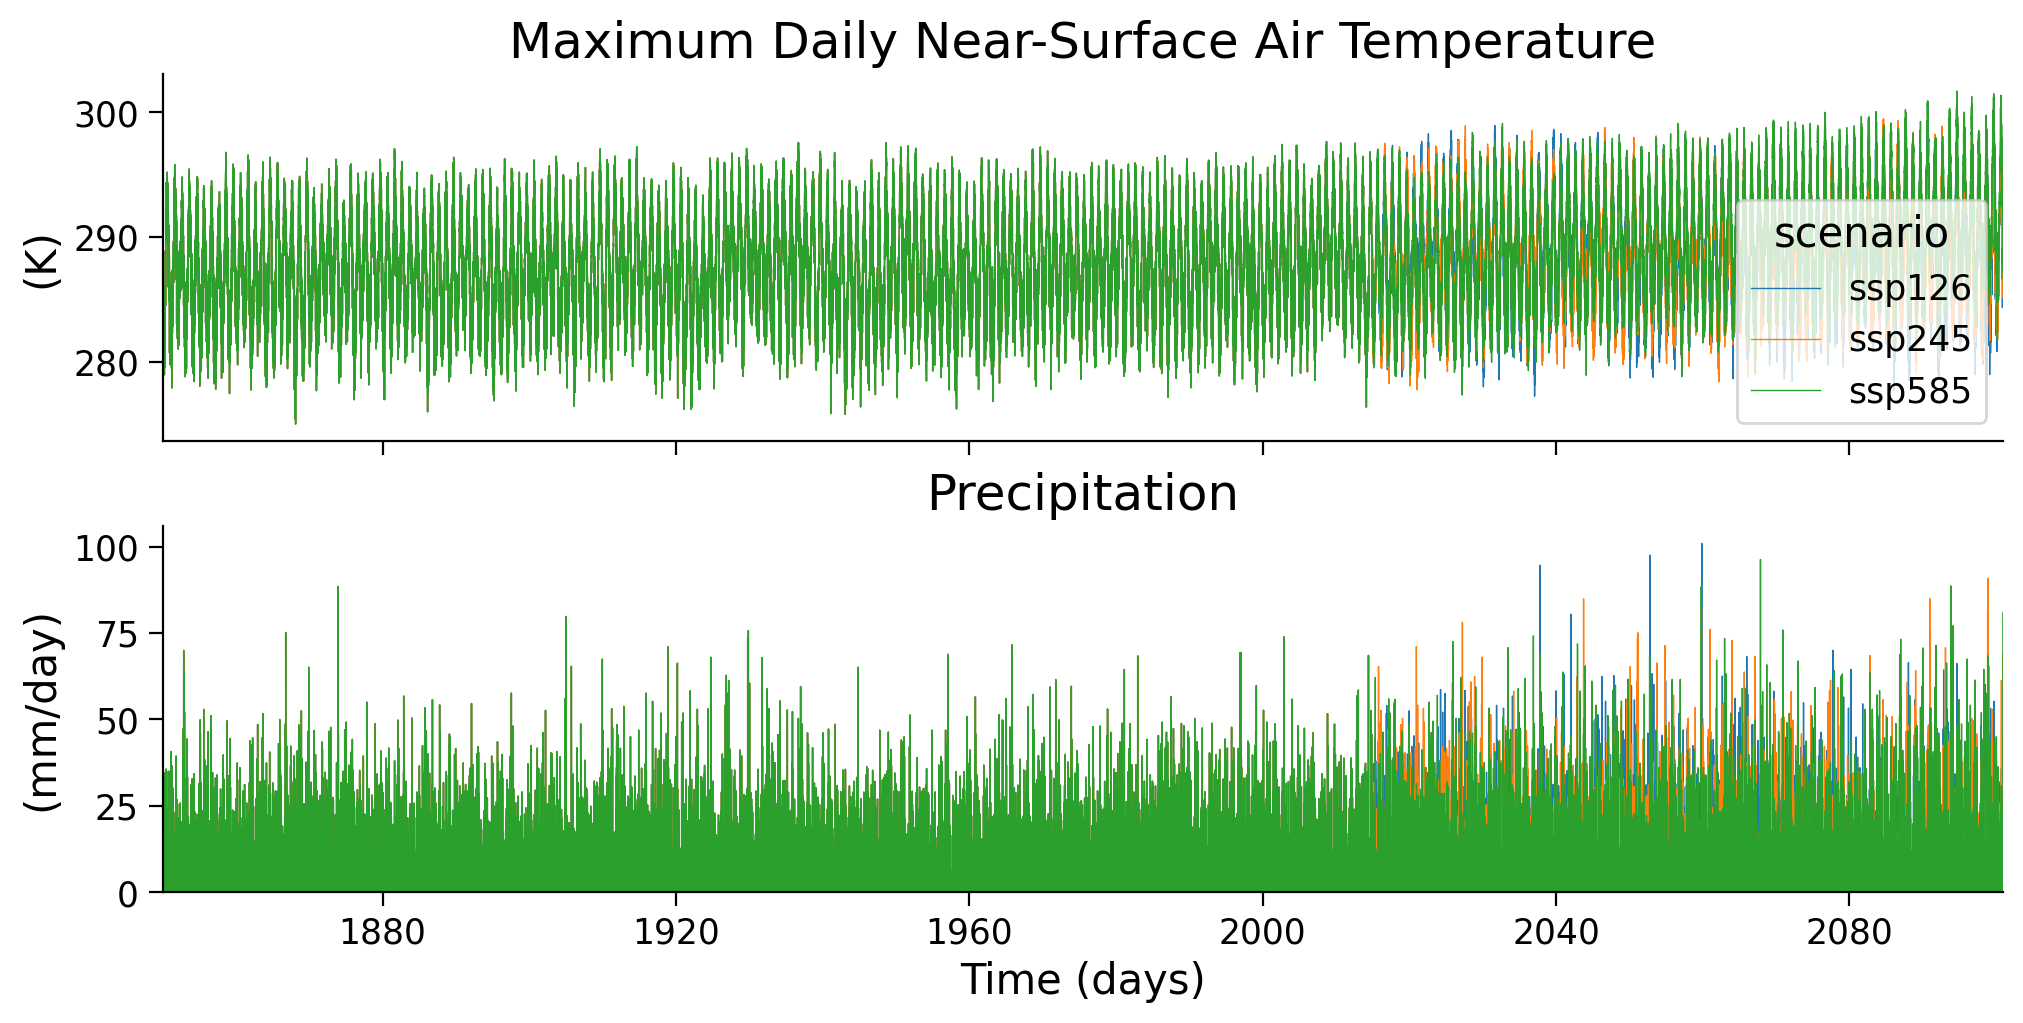

In [44]:
# setup plot
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 5), constrained_layout=True)

# plot maximum daily near surface air temperature 'tasmax' time series
# of all scenarios
data_city["tasmax"].plot(hue="scenario", ax=ax[0], lw=0.5)

# plot precipitation 'pr' time series of all scenarios
data_city["pr"].plot(hue="scenario", ax=ax[1], lw=0.5, add_legend=False)

# plot aesthetics
ax[0].set_title("Maximum Daily Near-Surface Air Temperature")
ax[1].set_title("Precipitation")
ax[0].set_xlabel("")
ax[1].set_xlabel("Time (days)")
ax[0].set_ylabel("(K)") # Kelvin
ax[1].set_ylabel("(mm/day)")
# set limits
ax[0].set_xlim(datetime(1850, 1, 1), datetime(2100, 12, 31))
ax[1].set_ylim(0, None);

In the previous tutorials, we have been operating on annual maxima data - looking at the most extreme event observed in each year. We will do the same here: for each year, we take the day with the highest temperature or the largest amount of rainfall, respectively.

In [ ]:
# setup plot
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 5), constrained_layout=True)

# choose a variable, take the annual maximum and plot time series of all scenarios
data_city["tasmax"].resample(time="1Y").max().plot(
    hue="scenario", ax=ax[0], lw=2)
data_city["pr"].resample(time="1Y").max().plot(
    hue="scenario", ax=ax[1], lw=2, add_legend=False
)

# plot aesthetics
ax[0].set_title("Annual Maximum of Daily Maximum Near-Surface Air Temperature")
ax[1].set_title("Annual Maximum of Daily Precipitation")
ax[0].set_xlabel("")
ax[1].set_xlabel("Time (years)")
ax[0].set_ylabel("(K)")
ax[1].set_ylabel("(mm/day)")
# set limits
ax[0].set_xlim(datetime(1850, 1, 1), datetime(2100, 12, 31))
ax[1].set_ylim(0, None);

/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


## Questions 3
1. Describe the plot - what do you see for the two variables, over time, between scenarios?

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_ExtremesandVariability/solutions/W2D3_Tutorial6_Solution_66d5a702.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_3")

# Section 4: Differences in the Historical Period

As in the previous tutorial we want to compare consecutive 30-year periods in the past: therefore take the historical run (1850-2014), and look at the annual maximum daily precipitation for the last three 30-year periods. We only need to look at one scenario because they all use the historical run until 2014.

In [ ]:
# take max daily precip values from Madrid for three climate normal periods
pr_city = data_city["pr"]
pr_city_max = pr_city.resample(time="1Y").max()

data_period1 = (
    pr_city_max.sel(scenario="ssp245", time=slice("2014"))
    .sel(time=slice("1925", "1954"))
    .to_dataframe()["pr"]
)
data_period2 = (
    pr_city_max.sel(scenario="ssp245", time=slice("2014"))
    .sel(time=slice("1955", "1984"))
    .to_dataframe()["pr"]
)
data_period3 = (
    pr_city_max.sel(scenario="ssp245", time=slice("2014"))
    .sel(time=slice("1985", "2014"))
    .to_dataframe()["pr"]
)

Plot the histograms of annual maximum daily precipitation for the three climate normals covering the historical period. What do you see? Compare to the analysis in the previous tutorial where we analyzed sea level height. Any similarities or differences? Why do you think that is?

In [ ]:
# collect scenario data of all climate normal periods in historical time frame
periods_data = [data_period1, data_period2, data_period3]
periods_labels = ["1925-1954", "1955-1984", "1985-2014"]

# plot histograms for climate normals during historical period
fig, ax = plt.subplots()
colors = ['C0','C1','C2']

# repeat histogram/PDF plot for all periods
for counter, period in enumerate(periods_data):
    sns.histplot(
        period,
        bins = np.arange(20, 90, 5),
        color = colors[counter],
        element = "step",
        alpha = 0.5,
        kde = True,
        label = periods_labels[counter],
        ax = ax,
    )

# aesthetics
ax.legend()
ax.set_xlabel("Annual Maximum Daily Precipitation (mm/day)")

In [ ]:
# calculate moments of the data
periods_stats = pd.DataFrame(index=["Mean", "Standard Deviation", "Skew"])

# collect data of periods
periods_data = [data_period1, data_period2, data_period3]
periods_labels = ["1925-1954", "1955-1984", "1985-2014"]

# repeat statistics calculation for all periods
for counter, period in enumerate(periods_data):
    # calculate mean, std and skew and put it into DataFrame
    periods_stats[periods_labels[counter]] = [
        period.mean(),
        period.std(),
        period.skew(),
    ]

periods_stats = periods_stats.T
periods_stats

Now, we fit a GEV to the three time periods, and plot the distributions using the gev.pdf function:

In [ ]:
# reminder of how the fit function works
shape, loc, scale = gev.fit(data_period1.values, 0)
print(f"Fitted parameters:\nShape: {shape:.5f}, Location: {loc:.5f}, Scale: {scale:.5f}")

In [ ]:
# fit GEV distribution for three climate normals during historical period
params_period1 = gev.fit(data_period1, 0)
shape_period1, loc_period1, scale_period1 = params_period1
params_period2 = gev.fit(data_period2, 0)
shape_period2, loc_period2, scale_period2 = params_period2
params_period3 = gev.fit(data_period3, 0)
shape_period3, loc_period3, scale_period3 = params_period3

In [ ]:
# plot corresponding PDFs of GEV distribution fits

# create x-data in precipitation range
x = np.linspace(20, 90, 1000)

# collect all fitted GEV parameters
shape_all = [shape_period1, shape_period2, shape_period3]
loc_all = [loc_period1, loc_period2, loc_period3]
scale_all = [scale_period1, scale_period2, scale_period3]

periods_labels = ["1925-1954", "1955-1984", "1985-2014"]
colors = ['C0','C1','C2']

# setup plot
fig, ax = plt.subplots()

# repeat plotting for all climate normal periods
for i in range(len(periods_labels)):
    # plot GEV PDFs
    ax.plot(
        x,
        gev.pdf(x, shape_all[i], loc=loc_all[i], scale=scale_all[i]),
        c=colors[i],
        lw=3,
        label=periods_labels[i],
    )

# aesthetics
ax.legend()
ax.set_xlabel("Annual Maximum Daily Precipitation (mm/day)")
ax.set_ylabel("Density")

In [ ]:
# show the parameters of the GEV fit
parameters = pd.DataFrame(index=["Location", "Scale", "Shape"])
parameters["1925-1954"] = [loc_period1, scale_period1, shape_period1]
parameters["1955-1984"] = [loc_period2, scale_period2, shape_period2]
parameters["1985-2014"] = [loc_period3, scale_period3, shape_period3]

parameters = parameters.T
parameters.round(4)  # .astype('%.2f')

Now we will create a return level plot for the three periods. To do so we will be using some helper functions defined at the beginning of the tutorial, most of which you have seen before.  In particular we will use `fit_return_levels()` to generate an xr.Dataset that contains empirical and GEV fits, as well as confidence intervals, and `plot_return_levels()` to generate a plot from this xr.Dataset with calculated confidence intervals shaded (alpha printed below).

These functions can also be found in `gev_functions.py`.

In [ ]:
fit_period1 = fit_return_levels(
    data_period1, np.arange(1.1, 1000, 0.1), N_boot=100, alpha=0.05
)
fit_period2 = fit_return_levels(
    data_period2, np.arange(1.1, 1000, 0.1), N_boot=100, alpha=0.05
)
fit_period3 = fit_return_levels(
    data_period3, np.arange(1.1, 1000, 0.1), N_boot=100, alpha=0.05
)

In [ ]:
fig, ax = plt.subplots()
plot_return_levels(fit_period1, c="C0", label="1925-1954", ax=ax)
plot_return_levels(fit_period2, c="C1", label="1955-1984", ax=ax)
plot_return_levels(fit_period3, c="C2", label="1985-2014", ax=ax)
ax.set_xlim(1.5, 1000)
ax.set_ylim(40, 140)

ax.legend()
ax.set_ylabel("Return Level (mm/day)")
ax.set_xlabel("Return Period (years)")

## Questions 4

1. What do you conclude for the historical change in extreme precipitation in this city? What possible limitations could this analysis have? (How) could we address this?

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_ExtremesandVariability/solutions/W2D3_Tutorial6_Solution_63eff724.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_1")

# Section 5: Climate Futures

Now let's look at maximum precipitation in possible climate futures: the years 2071-2100 (the last 30 years). For comparison we use the historical period, 1850-2014.

In the next box we select the data, then you will plot it as a coding exercise:

In [ ]:
data_city = data.sel(city=city, model="MPI-ESM1-2-HR")

# select the different scenarios and periods, get the annual maximum, store in DataFrames
data_hist = (
    data_city["pr"]
    .sel(scenario="ssp126", time=slice("1850", "2014"))
    .resample(time="1Y")
    .max()
    .to_dataframe()["pr"]
)
data_city_fut = (
    data_city["pr"].sel(time=slice("2071", "2100")).resample(time="1Y").max()
)
data_ssp126 = data_city_fut.sel(scenario="ssp126").to_dataframe()["pr"]
data_ssp245 = data_city_fut.sel(scenario="ssp245").to_dataframe()["pr"]
data_ssp585 = data_city_fut.sel(scenario="ssp585").to_dataframe()["pr"]

## Coding Exercises 5
Differences between climate scenarios:

Repeat the analysis that we did above for three different periods, but now for three different climate scenarios, and the historical period for comparison. The four cells below are prepared for the following purposes:
1. Create a figure that displays the histograms of the four records. Find a useful number and spacing of bins (via the `bins=` keyword to `sns.histplot()`). Calculate the moments.
2. Fit GEV distributions to the four records using the same commands as above. Use the `gev.pdf()` function to plot the fitted distributions.
3. Inspect location, scale and shape parameters
4. Create a return-level plot using the `ef.plot_levels_from_obj()` function.

In [ ]:
# setup plot
fig, ax = plt.subplots()

#################################################
## TODO for students:                                                                ##
## Put the data, labels, and colors you want to plot in lists.                       ##
## Additionally, create an array with a useful number and spacing of bins.           ##
## Below the plotting procedure, calculate the moments for all scenarios.            ##
# Remove or comment the following line of code once you have completed the exercise:
raise NotImplementedError("Student exercise: Put the data, labels, and colors you want to plot in lists, create an array with a useful number and spacing of bins, and calculate the moments for all scenarios.")
#################################################

# collect data of all scenarios, labels, colors in lists, and define bin_range
scenario_data = ...
scenario_labels = ...
colors = ...
bin_range = ...

# create histograms/ PDFs for each scenario and historical
for counter, data_src in enumerate(scenario_data):
    sns.histplot(
        data_src,
        bins=bin_range,
        color=colors[counter],
        element="step",
        stat="density",
        alpha=0.3,
        lw=0.5,
        line_kws=dict(lw=3),
        kde=True,
        label=scenario_labels[counter],
        ax=ax,
    )

# aesthetics
ax.legend()
ax.set_xlabel("Annual Maximum Daily Precipitation (mm/day)")

# calculate moments
periods_stats = pd.DataFrame(index=["Mean", "Standard Deviation", "Skew"])
column_names = ...

for counter, data_src in enumerate(scenario_data):
    periods_stats[column_names[counter]] = ...

periods_stats = periods_stats.T
periods_stats

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_ExtremesandVariability/solutions/W2D3_Tutorial6_Solution_f0cfaef4.py)

*Example output:*

<img alt='Solution hint' align='left' width=775.0 height=575.0 src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D3_ExtremesandVariability/static/W2D3_Tutorial6_Solution_f0cfaef4_2.png>



In [ ]:
#################################################
## TODO for students:                                                                  ##
## Put the data you want to plot in a list.                                            ##
## Then complete the for loop by adding a fitting and plotting procedure.              ##
# Remove or comment the following line of code once you have completed the exercise:
raise NotImplementedError("Student exercise: Put the data you want to plot in a list. Then complete the for loop by adding a fitting and a plotting procedure for the GEV distributions.")
#################################################

# collect data of all scenarios in a list, define labels and colors
scenario_data = ...
scenario_labels = ["Historical, 1850-2014", "SSP-126, 2071-2100", "SSP-245, 2071-2100", "SSP-585, 2071-2100"]
colors = ["k", "C0", "C1", "C2"]

# initialize list of scenario_data length
shape_all = [x*0 for x in range(len(scenario_data))]
loc_all = [x*0 for x in range(len(scenario_data))]
scale_all = [x*0 for x in range(len(scenario_data))]

fig, ax = plt.subplots()
x = np.linspace(20, 120, 1000)

# repeat fitting and plotting for all scenarios
for counter, scenario in enumerate(scenario_data):
    # fit GEV distribution
    shape_all[counter],loc_all[counter], scale_all[counter] = ...
    # make plots
    _ = ...

# aesthetics
ax.legend()
ax.set_xlabel("Annual Maximum Daily Precipitation (mm/day)")
ax.set_ylabel("Density");

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_ExtremesandVariability/solutions/W2D3_Tutorial6_Solution_d93c8bdf.py)

*Example output:*

<img alt='Solution hint' align='left' width=775.0 height=575.0 src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D3_ExtremesandVariability/static/W2D3_Tutorial6_Solution_d93c8bdf_0.png>



In [ ]:
#################################################
## TODO for students:                                                                ##
## Put the labels you want to show in a list.                                        ##
## Then complete the for loop by adding a fitting and plotting procedure             ##
## with previously applied functions: fit_return_levels() and plot_return_levels().  ##
# Remove or comment the following line of code once you have completed the exercise:
raise NotImplementedError("Student exercise: Put the labels you want to show in a list. Then complete the for loop by adding a fitting and a plotting procedure with previously applied functions: fit_return_levels() and plot_return_levels().")
#################################################

# collect data of all scenarios in a list, define labels and colors
scenario_data = [data_hist, data_ssp126, data_ssp245, data_ssp585]
scenario_labels = ...
colors = ["k", "C0", "C1", "C2"]

# initialize list for fit output
fit_all_scenarios = [0, 0, 0, 0]

# setup plot
fig, ax = plt.subplots()

# repeat fitting and plotting of the return levels for all scenarios
# using fit_return_levels() and plot_return_levels()
for counter, scenario in enumerate(scenario_data):
    fit_all_scenarios[counter] = ...
    _ = ...

# aesthetics
ax.set_xlim(1, 200)
ax.set_ylim(30, 110)
ax.set_ylabel("Return Level (mm/day)")
ax.set_xlabel("Return Period (years)")

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_ExtremesandVariability/solutions/W2D3_Tutorial6_Solution_b99eab92.py)

*Example output:*

<img alt='Solution hint' align='left' width=775.0 height=575.0 src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D3_ExtremesandVariability/static/W2D3_Tutorial6_Solution_b99eab92_6.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Coding_Exercise_5")

## Questions 5

1. What can you say about how extreme precipitation differs between the climate scenarios? Are the differences large or small compared to periods in the historical records? What are the limitations? Consider the x-axis in the return-level plot compared to the space covered by the data (only 30 years). How could we get more information for longer return periods?

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_ExtremesandVariability/solutions/W2D3_Tutorial6_Solution_e25db290.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_5")

# Summary
In this tutorial, you've learned how to analyze climate model output to investigate the changes in extreme precipitation patterns over time under various emission scenarios and the historical period. Specifically, we've focused on three future Shared Socioeconomic Pathways (SSPs) scenarios, which represent potential futures based on different assumptions about greenhouse gas emissions.

You've explored how to fit Generalized Extreme Value (GEV) distributions to the data and used these fitted distributions to create return-level plots. These plots allow us to visualize the probability of extreme events under different climate scenarios.

# Resources

The data for this tutorial was accessed through the [Pangeo Cloud platform](https://pangeo.io/cloud.html).  Additionally, a [notebook](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/W2D3_ExtremesandVariability/get_CMIP6_data_from_pangeo.ipynb) is available here that downloads the specific datasets we used in this tutorial.

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://pcmdi.llnl.gov/CMIP6/) multi-model ensemble, in particular the models MPI-ESM1-2-HR and MIROC6.

[MPI-ESM1-2-HR](https://gmd.copernicus.org/articles/12/3241/2019/) was developed and the runs conducted by the [Max Planck Institute for Meteorology](https://mpimet.mpg.de/en/homepage) in Hamburg, Germany.
[MIROC6](https://doi.org/10.5194/gmd-12-2727-2019) was developed and the runs conducted by a japanese modeling community including the Japan Agency for Marine-Earth Science and Technology [(JAMSTEC)](https://www.jamstec.go.jp/e/), Kanagawa, Japan, Atmosphere and Ocean Research Institute [(AORI)](https://www.aori.u-tokyo.ac.jp/english/), The University of Tokyo, Chiba, Japan, National Institute for Environmental Studies [(NIES)](https://www.nies.go.jp/index-e.html), Ibaraki, Japan, and [RIKEN Center for Computational Science](https://www.riken.jp/en/), Hyogo, Japan.

For references on particular model experiments see this [database](https://www.wdc-climate.de/ords/f?p=127:2).

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).